<a href="https://colab.research.google.com/github/adefgreen98/NLU2021-Assignment2/blob/main/code/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Understanding 2021 - Assignment 2: NERs & Dependency Parsing

_Federico Pedeni, 223993_

### Setup

The following cells are needed in order to perform automatic creation of the correct directory structure. Please deactivate them in case this is not desired.

In [1]:
!git clone https://github.com/adefgreen98/NLU2021-Assignment2.git
!mv NLU2021-Assignment2/code/conll.py ./

Cloning into 'NLU2021-Assignment2'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 79 (delta 17), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (79/79), done.


In [2]:
import zipfile
import os

# Extract assignment data
if not os.path.exists('data'):
    with zipfile.ZipFile("NLU2021-Assignment2/data/conll2003.zip") as zipref:
        zipref.extractall('data')

### Requirements

In [3]:
# Needed to update spacy in Google Colab

# !pip install --upgrade spacy

In [4]:
import itertools 

import spacy
import pandas as pd
import seaborn as sn
import sklearn
from sklearn.metrics import classification_report

from conll import *

In [5]:

!python -m spacy download en_core_web_sm

if spacy.__version__.startswith('3'):
    nlp = spacy.load('en_core_web_sm')
else:
    nlp = spacy.load('en')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


### Named entity lanbels conversion from SpaCy format to CoNLL format

SpaCy uses a much wider set of labels compared to the general CoNLL 4 tags. So, in order to evaluate SpaCy's parser performance, SpaCy entity tags must be converted to the CoNLL format. At this purpose, a dictionary containing a label map is declared below, which is going to be used over the execution. 

However, the assignment of new labels has been arbitrarily defined, since there is no official information on how to perform it. The map has been created following general information on CoNLL 2003 labels that can be found [here](https://www.clips.uantwerpen.be/conll2003/ner/annotation.txt). 

The following cell has been used to gather information for label conversions.

In [6]:
if spacy.__version__.startswith('3'):
    for el in nlp.meta["labels"]["ner"]:
        print(el, ": ", spacy.explain(el))
else:
    for el in nlp.entity.labels:
        print(el, ": ", spacy.explain(el))
    
for el in nlp.meta["labels"]["ner"]:
    print(el, ": ", spacy.explain(el))

CARDINAL :  Numerals that do not fall under another type
DATE :  Absolute or relative dates or periods
EVENT :  Named hurricanes, battles, wars, sports events, etc.
FAC :  Buildings, airports, highways, bridges, etc.
GPE :  Countries, cities, states
LANGUAGE :  Any named language
LAW :  Named documents made into laws.
LOC :  Non-GPE locations, mountain ranges, bodies of water
MONEY :  Monetary values, including unit
NORP :  Nationalities or religious or political groups
ORDINAL :  "first", "second", etc.
ORG :  Companies, agencies, institutions, etc.
PERCENT :  Percentage, including "%"
PERSON :  People, including fictional
PRODUCT :  Objects, vehicles, foods, etc. (not services)
QUANTITY :  Measurements, as of weight or distance
TIME :  Times smaller than a day
WORK_OF_ART :  Titles of books, songs, etc.
CARDINAL :  Numerals that do not fall under another type
DATE :  Absolute or relative dates or periods
EVENT :  Named hurricanes, battles, wars, sports events, etc.
FAC :  Buildings, 

In [7]:

# Labelmaps converted to CoNLL according to https://www.clips.uantwerpen.be/conll2003/ner/annotation.txt
labelmap = {
    'CARDINAL': 'out',
    'DATE': 'out',
    'EVENT': 'MISC',
    'FAC': 'LOC',
    'GPE': 'LOC',
    'LANGUAGE': 'MISC',
    'LAW': 'out',
    'LOC': 'LOC',
    'MONEY': 'out',
    'NORP': 'MISC',
    'ORDINAL': 'out',
    'ORG': 'ORG',
    'PERCENT': 'out',
    'PERSON': 'PER',
    'PRODUCT': 'out',
    'QUANTITY': 'out',
    'TIME': 'out',
    'WORK_OF_ART': 'out',
    '': 'out' # label for tokens that are not part of entities
}

def convert_tag(tk:spacy.tokens.Token):
    return (tk.ent_iob_ + ('-' + labelmap[tk.ent_type_])) if labelmap[tk.ent_type_] != 'out' else 'O'

### Dataset Loading

For utility reasons, a custom loading function has been developed. It basically does the same thing that could do the `load()` method of `conll.py`, that is to return a list of lists representing sentences, each one containing tuples of `(token, IOBtag-label)` for tokens in the sentence. However, it also directly gets the entities per each sentence while cycling over the text dataset: this is done thanks to a temporary entity object, that is appended only when it is closed, that happens to be when either there is a new entity or next token is not part of any entity. If two components of the same entity do not share the same label, an exception is raised.

In [8]:
# Format of dataset: <TOKEN> <POS> <IOB part-of speech tag> <TAG>

def load_dataset(mode):
    res = {
        'sentences': [],
        'ners': []
    }
    pth = f'data/{mode}.txt'
    
    idx = 0

    tmpsentence = []
    tmpentity = []
    tmp_entities_in_sentence = []

    tmpmisc = None

    with open(pth, 'rt') as file:
        for line in file:
            idx += 1
            if line == '\n': # arrived at the end of a sentence
                if len(tmpsentence) > 0:
                    # flushes the current sentence
                    res['sentences'].append(' '.join(tmpsentence))
                    tmpsentence = []

                    # flushes the last entity in entity list for sentence
                    if len(tmpentity) > 0: tmp_entities_in_sentence.append(tmpentity)
                    tmpentity = []
                    
                    # flushes entity list
                    res['ners'].append(tmp_entities_in_sentence)
                    tmp_entities_in_sentence = []
                continue
            elif line.startswith('-DOCSTART-'): # excludes lines separating documents
                continue
            else:
                if len(line.split()) != 4: 
                    print(f"Error: line with size {len(line.split())} at index {index}")
                    
                token, pos, tag1, tag2 = line.split() 
                tmpsentence.append(token)

                if tag2.startswith('B'): # starts a new entity
                    if len(tmpentity) > 0: # another one is already cached, so it must be appended
                        tmp_entities_in_sentence.append(tmpentity)
                        tmpentity = [(token, tag2)]
                    else:
                        tmpentity = [(token, tag2)]
                elif tag2.startswith('I'): # continues current entity
                    currtag = tag2.split('-')[1]
                    oldtag =  tmpentity[-1][1].split('-')[1]
                    if currtag != oldtag: 
                        raise RuntimeError(f"not corresponding tags at index {idx}; tags are '{currtag}' (new) and '{oldtag}' (old)")
                    tmpentity.append((token, tag2))
                elif tag2.startswith('O'): 
                    if len(tmpentity) > 0: tmp_entities_in_sentence.append(tmpentity)
                    tmpentity = [(token, tag2)]
                else:
                    print(f"Error: wrong tag detected at line {idx}, line: {line.encode()}")

    return res


In [9]:
dataset = load_dataset('test')

### Retokenization

In this section it is declared a **retokenizing** method that from a `Doc` object returns a sentence parsed in CoNLL format: this is a list of tuples with token text and its IOB tag plus the label. However, parsed tokens do not match exactly original SpaCy tokens: SpaCy tokenization is different from the dataset's one, mainly because the former tends to split dates and tokens containing a `-` symbol in multiple parts, giving them also new IOB tag and label which are inconsistent with the latter's. Thus, inside `retokenize()` it is kept a temporary word object, which stores tokens' joined texts and the label for the current token; this is done thanks to the `Token.whitespace_` attribute, that determines when a token should be considered as over. 

The process of separation is the following one: whenever there is no whitespace between two tokens, that `Token.whitespace_` is the empty string and thus has length 0, the current token should be appended to the temporary word text; if its label is different from the temporary one, an exception is raised, but this should not happen when using `train.txt` and `test.txt`. The temporary entity is considered closed, and thus appended at the sentence list, in 2 cases:
- current token is the last of the sentence, so that if the entity is not appended then it is lost;
- current token is the last of the temporary word, thus there is a non-empty whitespace after it and the current entity is not empty (otherwise it would be a common text token).

*Note*: the core of this retokenization happens to be in the `continue` at the middle of the cell; it allows to skip the appending part at the end of the `for` loop when an entity is not closed yet. The cases in which it is excecuted are the ones where the subsequent whitespace has zero length but the token is not the last one of the sentence, so that it could be that the next one is part of the current word too.

This function also does 2 more things: for first, it directly converts SpaCy labels to corresponding CoNLL labels, while appending tokens to the sentence list. Then, it also keeps an **index conversion table**, used to map old SpaCy indexes to their correspondent index in the new CoNLL-like tokenization; this will be used in Exercise 3.


In [10]:

def retokenize(doc:spacy.tokens.Doc):
    parsed_sent = []

    # Index conversion table from token.i to CoNLL sentence index (needed for ex3)
    # NOTE: Index-mapping is performed in an early-manner, so that it always follows actual addition to entity (ie: += tk.text) 
    #       but happens befor actual list.append() of the entity, so that the target index is increased only when list is modified
    index_conversion_table = {}

    # Multi-token word container
    tmpword = ['', None]

    for tk in doc:
        # Init. variable that will be either token text or multi-token-entity concatenated tokens
        text = None
        
        # label converted according to CoNLL standard (or 'O' when is not part of an entity)
        conv_label = convert_tag(tk)

        ### MULTI-TOKEN word JOIN ###
        if len(tk.whitespace_) == 0: # current multi-token word must be expanded
            tmpword[0] += tk.text
            index_conversion_table[tk.i] = len(parsed_sent)
            
            if tmpword[1] is None: tmpword[1] = conv_label 
            else:
                if tmpword[1] != conv_label:
                    if tmpword[1] == 'O' or conv_label == 'O':
                        pass
                    else:
                        if tmpword[1].split('-')[1] != conv_label.split('-')[1]: raise ValueError("not matching labels for sentence {}".format(sent))
            
            if tk.i == (len(doc) - 1): # last multi-token entity of the sentence
                if len(tmpword[0]) > 0:
                    text = tmpword[0]
                    conv_label = tmpword[1]
                else:
                    text = tk.text
                    conv_label = conv_label
                tmpword = ['', None]
            else:
                ##### NOTE: this is the core that allows to jump to next token without flushing tmpword immediately!! #####
                continue 
        else:
            if len(tmpword[0]) > 0: # cached multi-token entity is finished
                tmpword[0] += tk.text
                index_conversion_table[tk.i] = len(parsed_sent)

                if tmpword[1] != conv_label:
                    # since there are very very few (5 in test.txt) cases where multi-token entities have different tags, a rough conversion is simply applied 
                    conv_label = tmpword[1] 
                            
                text = tmpword[0]
                conv_label = tmpword[1]
                tmpword = ['', None]
            else: # no multi-token entity cached
                text = tk.text
                index_conversion_table[tk.i] = len(parsed_sent)
                
                conv_label = conv_label
        
        
        parsed_sent.append((text, conv_label))
    
    return parsed_sent, index_conversion_table



### Note on Exercises

In the following part of this notebook are presented the functions to solve the exercises. They are all designed to take as input one `Doc` object, so that they can be executed independently during the same loop: since SpaCy parsing requires some time, it is convenient to perform it just one time per sentence and then store results in separate objects.

### 1) Evaluate spaCy NER model using CoNLL evaluation script on CoNLL 2003 data 

For first, this cell creates a map from combined IOB tags and labels to a fixed set of indices: this is needed because `sklearn.metrics.classification_report()` only accepts list of class-indexes as input. 

After that, it comes the main part of this exercise, which is the function to obtain metrics by confronting SpaCy hypotheses with ground truths. It initially creates 2 lists for the ground truth, where the entity list of the current sentence is flattened to obtain tokens and labels indexed in a handy way. This is needed because of the custom load function, which returns tags for entities already grouped in the second list. 

Then, it retokenizes the `Doc` as explained above, discarding the index conversion table; finally, for each sentence it stores in two separate lists token-level predictions and ground truths, while cycling jointly over parsed sentence and ground truth references. In case of size mismatch, it throws an error, but it has not been shown neither in `training.txt` nor in `test.txt` files. In the meantime, it also converts labels to unique indexes so that they can be managed by the classification function.

Thanks to the retokenizing, both results for the first and the second part of this exercise are produced: the first is the result of the `classification_report()` function, while the second directly uses parsed sentences lists as they are returned by this function.

In [11]:

# Unique set of mapping labels to indexes (needed for sklearn.metrics.classification_report())
# - (converted to dict for better performance, otherwise at each step would be needed list.index(token))
__index_labels__ = [el[0] + el[1] for el in itertools.product(['B-', 'I-'], ['LOC', 'MISC', 'ORG', 'PER'])] + ['O']
__index_labels__ = {lab: idx for idx, lab in enumerate(__index_labels__)}

def get_accuracies(doc:spacy.tokens.Doc, ents:list, labels=__index_labels__):
    gt_sent = [
        # all tokens from entities in a sentence
        [enttoken[0] for ent in ents for enttoken in ent], 
        # relative entity tags 
        [enttoken[1] for ent in ents for enttoken in ent]
    ]

    # needed for part 1
    preds = []
    truths = []

    parsed_sent, _ = retokenize(doc)
    
    if len(parsed_sent) != len(gt_sent[0]): 
        raise ValueError(f"inconsistent sentences length for parsed '{parsed_sent}' and ground truth '{gt_sent[0]}'")
    
    for hyp, ref in zip(parsed_sent, gt_sent[1]):

        # Part 1
        preds.append(labels[hyp[1]])
        truths.append(labels[ref])
    
    return {'part1': {'preds': preds, 'truths': truths}, 'part2': parsed_sent}



### 2) Grouping of Entities. Write a function to group recognized named entities using `noun_chunks` method of SpaCy. Analyze the groups in terms of most frequent combinations (i.e. NER types that go together).

The target for this part of the assignment is to identify *groups of entities* inside sentences, in the sense of entities that are inside the same noun chunk and therefore are bound together; also, in the end are retrieved also frequency counts of entity groups (see the Results part, this is not included in this function). 

**Note**: Grouping has been performed on SpaCy classes and not on CoNLL ones, and the order in which labels appear has not considered to be relevant for this task (see Results section for counts of groups).

Grouping of entities is implemented in the following way: through `noun_chunks` and `ents` attributes of `Token`, the two lists of chunks and entities are generated; the function will iterate over the two of them in parallel, while checking if entnties belong to the curent chunk or not. If an entity does not belong to the current chunk, for first it is added a new empty list to the list of groups, because without any doubt the current group should be considered as closed. In this case, two cases are given:
+ current entity is part of one of the following chunks, which means that a forward check will find the exact chunk where it belongs; in this case nothing should be done, because the entity will be processed in next steps;
+ current entity is not part of any chunk, therefore the forward check reaches the end of noun chunks without finding any match; in this case the entity should be added immediately to the result, as outlier of noun chunks, and after that a new group is prepared to be used (by adding `[]`). 

**Note**: here it is assumed that outlier entities cannot form groups by definition. Solving this task without this assumption would require a much more complex analysis and a different way of detecting groups from `noun_chunks`.

In case the entity is actually part of current chunk, then it must be added to the current group, which is the last one of the group list; a check on the size of the last element of the group is performed, to avoid having multiple useless empty lists inside the result. At the end of this branch, the current group index is decremented, so that in the end the current group will remain the same and other entities may be appended to it.

Finally, if the loop reaches the end of the chunk list before processing all entities, it must be that there are other outliers in the final part of the sentence and therefore after the last noun chunk: these are all added thanks to a loop that adds all of them as independent groups.

The final result is a list of lists, where each list represents a group of entities and entities are represented by strings of labels' names. These will be used in the Results part to create unique labels for groups, to compute frequency counts.


In [12]:
def group_ents(doc:spacy.tokens.Doc):

    res = [] # current sentence
    
    noun_chunks = list(doc.noun_chunks)
    entities = list(doc.ents)
    
    i = 0 # index for entities
    j = 0 # index for noun_chunks
    
    # iterating jointly over entities and noun chunks
    while i < len(entities) and j < len(noun_chunks):

        is_not_contained = any([e not in noun_chunks[j] for e in entities[i]])
        if is_not_contained:
            
            if (len(res) == 0 or (len(res) > 0 and len(res[-1]) > 0)): res.append([]) # start a new group, bc current one is finished

            # FORWARD CHECK on outlier entities
            tmp = j
            while tmp < len(noun_chunks): # NOTE: supposing all items in entity belong to same noun chunk, if they belong to one!
                is_contained = any([e in noun_chunks[tmp] for e in entities[i]])
                if is_contained: break
                else: tmp += 1

            if tmp == len(noun_chunks): # entity is an outlier or current noun chunk does not contain entities
                if len(res) > 0 and len(res[-1]) == 0: res[-1].append(entities[i][0].ent_type_) 
                else: res.append([entities[i][0].ent_type_])
                if i != len(entities) - 1: res.append([]) # prepares new group (for subsequent eventually not outliers)
                i += 1
            else: pass # will be explored later
        else:
            if len(res) == 0: res.append([entities[i][0].ent_type_]) # meaning this is the first entity of a noun chunk | NOTE: supposing all items in entity have the same label!!!
            else: res[-1].append(entities[i][0].ent_type_) # here i have already started a noun chunk, so i must append (--> actually a combination)
            i += 1
            j -= 1

        if j == len(noun_chunks) - 1: # if it has reached the end but other entities still remain, they must be added 
            while i < len(entities):
                if len(res[-1]) == 0: res[-1].append(entities[i][0].ent_type_)
                else: res.append([entities[i][0].ent_type_])
                i += 1
        j += 1
    
    return res

### 3) One of the possible post-processing steps is to fix segmentation errors. Write a function that extends the entity span to cover the full noun-compounds. Make use of compound dependency relation.

The idea behind the implementation of this exercise is that we can search for `compound` dependencies inside entities **subtrees** with a top down approach. In this way, we can solve the hardest parts of this task which are both chains of compound relationships (i.e. tokens being compounds of other compound tokens) and compounds referring to entities different from the one that is currently processed. 

In order to manage in an easier way entity comparisons, this time will be used a `set` to represent the entities in the sentence: while cycling over this set, for first it is retrieved the mapping from SpaCy indexes of tokens in current entity and their new position in retokenized sentence, so that inconsistencies will be avoided; this is mainly due to the fact that we will mostly work with the result list, that is already in CoNLL format (text plus tag) and follows that same tokenization. Furthermore, from `retokenize()` we get also already converted labels, so that we will directly work with the correct set of entity tags.

As initial step, we fix the current entity label, excluding all the out-of-entity tagged tokens in the entity; the first occurrence of a non-outside tag will be considered as the entity label, and in case the entity is not relevant it will be processed.

Then we start to analyze tokens inside the entity subtree, but only when these are tagged as `compound`. Whenever this happens, it can be only one of the following cases:
1. the token is part of current entity;
2. the token refers to a token belonging to the current entity, or is part of a chain of compounds that terminates in this entity;
3. the token is part of a different entity;
4. the token refers to a token belonging to another entity, or it is part of a chain-of-compounds leading to another entity.

For first, we check if the compound is part of another entity, which is the first `for` loop inside the `if` branch detecting if this is a compound; here come in handy Python's `set` objects, that allow to easily exclude this entity from the list to check. 

At this point, it is performed the check on chain-of-compounds: in a brief bottom-up search, a reference to the token is substituted with its head until it is found a non-compound token; if this is not part of the current entity, then the current token must be skipped, because it will be processed by future entities. Otherwise, we must first check that it is not already part of current entity, but we must pay attention also to the fact that we have actually retokenized the sentence; therefore, the quickest way to do this check is to find whether the new index of this token belongs to the current entity's index set. 

We also check if the compound has already been assigned to another entity, so that we avoid cases in which an entity is part of the subtree of another entity: in this case, the former would assign the compound before the latter, but the compound would be analyzed again by parent entity. Note that the opposite cannot happen: it is excluded by the bottom-up check that we performed before.

If this is not the case, then we can finally say that this token should be assigned to the current entity. Now we have to find its relative position with respect to the entity: it could be either before the first element of the entity or after the last element of the entity; otherwise, it would mean that it is part of the entity and this would be inconsistent with previous checks. 

The case in which its index is higher than the entity's end is easy: we can just assign to it the `'I'` tag plus the label of current entity without problems. The other case is more difficult, because we should check if other compounds belonging to this entity have been already assigned before this, so that they would represent a "new" start of the entity: to solve this, we use a list that keeps track of the referral token of a compound, meaning that if a compound is modified to be part of an entity then its corresponding value in the `changed` list is modified from `None` to the entity's `root` token. So, if we do not find an already assigned compound before the current one, we can safely assign the `'B'` tag to this one and set all the other elements of the entity as internal parts of the entity in final result list (change their tag to `'I'`). If instead we find another previous compound assigned, then we just tag this compound as internal part of the entity.

**Note**: we only check for compounds that come before the current token because generally each span returned by `subtree` yields token orederd according to sentence order; thus there cannot be compounds coming after the current one in the sentence that are already assigned too.

After processing the sentence, a CoNLL-formatted list is returned by transforming all internal lists to tuples (to be consistent with the syntax of `evaluate()` used elsewhere). 

In [13]:
def fix_compounds(doc:spacy.tokens.Doc):
    ents = set(doc.ents)
    res, index_conversion_table = retokenize(doc)
    res = [[el[0], el[1]] for el in res] # change to lists so that can be modified
    
    # mantained to check if another compound comes before this and has been already modified (they will be assigned the same entity.root)
    changed = [None for el in res]

    for ent in ents:
        
        ent_indexes = {index_conversion_table[tk.i] for tk in ent}
        
        # gets the correct label
        curr_label = None
        for i in ent_indexes:
            if res[i][1] != 'O':
                curr_label = res[i][1].split('-')[1]
                break

        # only executes if entity is relevant
        if curr_label != None:
            for tk in ent.subtree: 
                tk_converted_index = index_conversion_table[tk.i]
                if tk.dep_ == 'compound':
                    
                    # if this compound is part of another entity then must be skipped
                    is_ent = False
                    for other in ents.difference({ent}):
                        if tk in other:
                            is_ent = True
                            break
                    
                    if is_ent:
                        continue
                    else:
                        # if compound is part of a chain of compounds towards another entity then must be skipped
                        # NOTE: this works because usually compounds have out-to-in structure (meaning that if they belong to an entity then
                        #       their head is either referring to that entity or is their entity)
                        # Therefore, finds the first non-compound ancestor and verifies if it is inside the current entity
                        tmp = tk
                        while tmp.dep_ == 'compound':
                            tmp = tmp.head
                        if tmp not in ent:
                            continue

                        if tk_converted_index in ent_indexes or changed[index_conversion_table[tk.i]]: 
                            # this token is already either part of the entity or part of one of its tokens, or has already been modified as part of another entity
                            pass
                        else:  # not part of current entity but part of its subtree, so must fix segmentation
                            
                            changed[index_conversion_table[tk.i]] = ent.root
                            
                            if tk_converted_index < index_conversion_table[ent.start]: # compound is before start of the entity
                                exists_previous_compound = ent.root in changed[:index_conversion_table[tk.i]] 
                                # NOTE: only case in which the other compound is previous is checked, because we are cycling over a span ordered wrt. sentence order
                                
                                if not exists_previous_compound: 
                                    res[tk_converted_index][1] = 'B-' + curr_label # assigns the correct label to compound
                                    for i in range(index_conversion_table[ent.start], index_conversion_table[ent.end - 1] + 1):
                                        res[i][1] = 'I-' + curr_label
                                else: 
                                    res[tk_converted_index][1] = 'I-' + curr_label

                            elif tk_converted_index > index_conversion_table[ent.end - 1]: # compound after end of the entity
                                res[tk_converted_index] = 'I-' + curr_label
                            
                            else: 
                                print(ent)
                                print(ents.difference({ent}))
                                raise ValueError(f"this compound token ('{tk.text}') should be inside entity span but is not, in sentence: '{doc}'")
        
    return [(el[0], el[1]) for el in res]

### Results of Exercises

Here is the main loop that computes results for the three exercises, parsing the sentence just 1 time for all of them.

In [14]:
results_ex1 ={
    'part1': {'preds': [], 'truths': []},
    'part2': []
}

results_ex2 = []
results_ex3 = []

for sent, ents in zip(dataset['sentences'], dataset['ners']):
    doc = nlp(sent)
    res = get_accuracies(doc, ents)
    results_ex1['part1']['truths'].extend(res['part1']['truths'])
    results_ex1['part1']['preds'].extend(res['part1']['preds'])
    results_ex1['part2'].append(res['part2'])

    results_ex2.append(group_ents(doc))
    results_ex3.append(fix_compounds(doc))

#### **Exercise 1**


1) Report token-level performance (per class and total)
+ accuracy of correctly recognizing all tokens that belong to named entities (i.e. tag-level accuracy)

The following table recaps the model's performances, showing precision, recall and `f1`-score thanks to `classification_report()`; classes have been split also by their IOB tag. The accuracy is also visible, and it is overall `0.91`. 

We can see that the class where the model is most performant is the `'O'` class: this could be explained by the fact that it is far wider than the others, containing all the tags that are not covered by CoNLL standard.


In [15]:
print(classification_report(results_ex1['part1']['truths'], results_ex1['part1']['preds'], target_names=list(__index_labels__.keys())))

              precision    recall  f1-score   support

       B-LOC       0.79      0.73      0.76      1668
      B-MISC       0.80      0.56      0.66       702
       B-ORG       0.52      0.34      0.41      1661
       B-PER       0.78      0.62      0.69      1617
       I-LOC       0.54      0.59      0.56       257
      I-MISC       0.59      0.37      0.46       216
       I-ORG       0.46      0.55      0.50       835
       I-PER       0.73      0.78      0.75      1156
           O       0.95      0.98      0.97     38323

    accuracy                           0.91     46435
   macro avg       0.68      0.61      0.64     46435
weighted avg       0.91      0.91      0.91     46435




2) report CoNLL chunk-level performance (per class and total); 
+ precision, recall, f-measure of correctly recognizing all the named entities in a chunk per class and total


In [16]:
# Note: List comprehension needed to extract tokens from entities, which are stored separately in lists inside dataset['ners']
res = evaluate([[tk for ent in sent for tk in ent] for sent in dataset['ners']], results_ex1['part2'])
pd_tbl = pd.DataFrame().from_dict(res, orient='index')
pd_tbl.round(decimals=3)

,p,r,f,s
PER,0.738,0.591,0.656,1617
LOC,0.776,0.719,0.746,1668
MISC,0.783,0.548,0.645,702
ORG,0.463,0.298,0.363,1661
total,0.690,0.537,0.604,5648


#### **Exercise 2**

In this block is declared a function that from a group (considered as `list`) returns the unique label representing that group. This is made just by rearranging the list of strings in alphabetical way, so that it is uniquely defined, and combining them with a `+` symbol. 

**Note**: this means that groups with same labels in different orders are considered equals. This can be justified by the fact that the importance of groups in this task is in their semantics, not in their synctactic occurrence, which means that it does not matter the order in which they appear but rather the fact itself that they appear together.

Frequency counts are obtained by cycling over result list, which contains lists of groups per sentence; each group in a sentence is associated with its unique label and increases the count for that label.

Two **histograms** have also been plotted for this exercise: 
+ the first one shows groups which are above a certain frequency threshold (hard-coded to `15`);
+ the second one is still a thresholded version of the frequency counts, but shows only groups with more than 1 tag (i.e. excludes groups of stand-alone entities).

Text(0.5, 0.98, 'Tag Frequencies (min. threshold 15)')

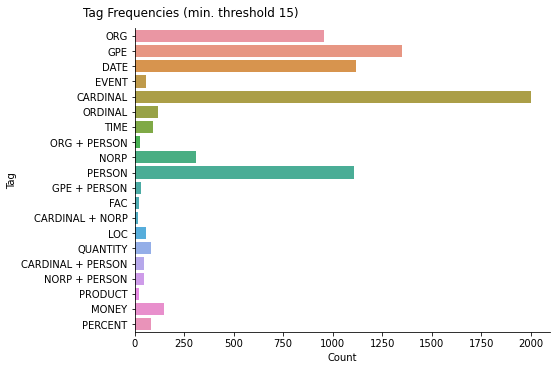

In [17]:
def get_unique_label(group:list):
    group.sort()
    return " + ".join(group)


counts = {}

for sent in results_ex2:
    for group in sent:
        lb = get_unique_label(group)
        try: counts[lb] += 1
        except KeyError: counts[lb] = 1

threshold = 15
all_counts = {k: v for k,v in counts.items() if v > threshold}
all_counts = pd.DataFrame.from_records([{'Tag': k, 'Count': v} for k,v in all_counts.items()])

# Plotting hist of frequencies above threshold
plot = sn.catplot(data=all_counts, y='Tag', x='Count', kind='bar')
plot.fig.subplots_adjust(top=0.92, right=1.5)
plot.fig.suptitle(f"Tag Frequencies (min. threshold {threshold})")

Text(0.5, 0.98, 'Tag Frequencies - Only multiple label groups (min. threshold 7)')

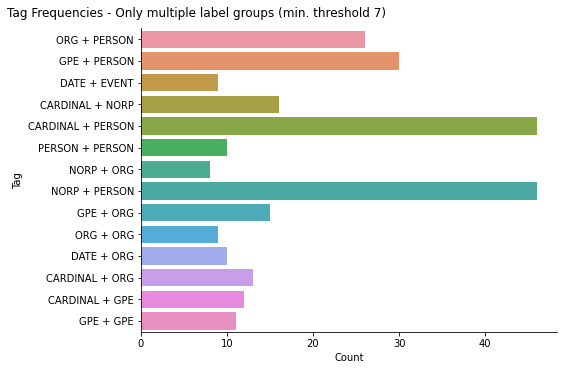

In [18]:
threshold = 7
bi_counts = {k: v for k,v in counts.items() if v > threshold and len(k.split('+')) > 1}
bi_counts = pd.DataFrame.from_records([{'Tag': k, 'Count': v} for k,v in bi_counts.items()])
plot = sn.catplot(data=bi_counts, y='Tag', x='Count', kind='bar')
plot.fig.subplots_adjust(top=0.92, right=1.5)
plot.fig.suptitle(f"Tag Frequencies - Only multiple label groups (min. threshold {threshold})")

#### **Comment on Exercise 2 Histograms**

It can be seen from the 1st histogram that multi-label groups have much lower statistical importance compared to 1-label groups, and only few of the formers have frequencies comparable to the latters' ones. 

The far higher count of `CARDINAL` could be due to many reasons: numbers are very common, and also other categories (like dates or quantities) could be wrongly classified as simple numbers, boostng its importance; but also the fact that many sentences in this dataset are about sports influences its value. This last reason is also linked to the high count for the multi-label group `CARDINAL + PERSON`, that appears in associations between players' numbers or scores and their names.

The distribution of frequencies for multi-label groups is further explained by the composition of the dataset: it is composed for a great part of geopolitical news, which cause the predominance of `NORP`, `GPE` and `ORG` combinations, especially with `PERSON`. 

#### **Exercise 3**

The results of this exercise are slightly worse than ones obtained without applying the `compound` check. This could be due to many facts: probably in this dataset is more common not to tag compounds as part of entities, or maybe they are just so rare that the function for their detection produces more damage than good. 

In [19]:
# NOTE: see results of Ex2 for explanation of the list comprehension
res = evaluate([[tk for ent in sent for tk in ent] for sent in dataset['ners']], results_ex3)
pd_tbl = pd.DataFrame().from_dict(res, orient='index')
pd_tbl.round(decimals=3)

,p,r,f,s
PER,0.600,0.482,0.534,1617
LOC,0.760,0.704,0.731,1668
MISC,0.783,0.548,0.645,702
ORG,0.450,0.291,0.353,1661
total,0.640,0.500,0.561,5648


### Appendix: Testing Custom Methods

In [20]:
### Ensure custom load function retrieves correct number of sentences ###
print("From load(): ", len(dataset['sentences']))
print("From read_corpus_conll(): ", len(read_corpus_conll('/content/data/test.txt')))

cnt = 0
for sent in read_corpus_conll('/content/data/test.txt'):
    if sent[0][0] == '-DOCSTART- -X- -X- O':
        cnt += 1
print("Count of unused rows in conll_load(): ", cnt)
print("Difference between CoNLL load() and custom load(): ", len(read_corpus_conll('/content/data/test.txt')) - len(dataset['sentences']))

From load():  3453
From read_corpus_conll():  3684
Count of unused rows in conll_load():  231
Difference between CoNLL load() and custom load():  231


In [21]:
### Retokenize + Index Conversion ###
idx = 131
doc = nlp(dataset['sentences'][idx])
sent, idx_table = retokenize(doc)
print(doc)
print(sent)
print({doc[k].text: sent[v] for k,v in  idx_table.items()})

Bowling : Wasim Akram 8.1-0-43-3 ( 9w , 1nb ) , Waqar Younis
[('Bowling', 'O'), (':', 'O'), ('Wasim', 'O'), ('Akram', 'O'), ('8.1-0-43-3', 'O'), ('(', 'O'), ('9w', 'B-MISC'), (',', 'O'), ('1nb', 'O'), (')', 'O'), (',', 'O'), ('Waqar', 'B-PER'), ('Younis', 'I-PER')]
{'Bowling': ('Bowling', 'O'), ':': (':', 'O'), 'Wasim': ('Wasim', 'O'), 'Akram': ('Akram', 'O'), '8.1': ('8.1-0-43-3', 'O'), '-': ('8.1-0-43-3', 'O'), '0': ('8.1-0-43-3', 'O'), '43': ('8.1-0-43-3', 'O'), '3': ('8.1-0-43-3', 'O'), '(': ('(', 'O'), '9w': ('9w', 'B-MISC'), ',': (',', 'O'), '1nb': ('1nb', 'O'), ')': (')', 'O'), 'Waqar': ('Waqar', 'B-PER'), 'Younis': ('Younis', 'I-PER')}


In [22]:
### Grouping entities ###
idx = -1
doc = nlp(dataset['sentences'][idx])
print(doc)

print([[(el.text, el.ent_iob_, el.ent_type_) for el in ent] for ent in doc.ents])
print([[(el.text, el.ent_iob_, el.ent_type_) for el in noun_chunk] for noun_chunk in doc.noun_chunks])

print(group_ents(doc))

The lanky former Leeds United defender did not make his England debut until the age of 30 but eventually won 35 caps and was a key member of the 1966 World Cup winning team with his younger brother , Bobby .
[[('Leeds', 'B', 'ORG'), ('United', 'I', 'ORG')], [('England', 'B', 'GPE')], [('the', 'B', 'DATE'), ('age', 'I', 'DATE'), ('of', 'I', 'DATE'), ('30', 'I', 'DATE')], [('35', 'B', 'CARDINAL')], [('1966', 'B', 'DATE')], [('World', 'B', 'EVENT'), ('Cup', 'I', 'EVENT')], [('Bobby', 'B', 'PERSON')]]
[[('The', 'O', ''), ('lanky', 'O', ''), ('former', 'O', ''), ('Leeds', 'B', 'ORG'), ('United', 'I', 'ORG'), ('defender', 'O', '')], [('his', 'O', ''), ('England', 'B', 'GPE')], [('the', 'B', 'DATE'), ('age', 'I', 'DATE')], [('35', 'B', 'CARDINAL'), ('caps', 'O', '')], [('a', 'O', ''), ('key', 'O', ''), ('member', 'O', '')], [('the', 'O', ''), ('1966', 'B', 'DATE'), ('World', 'B', 'EVENT'), ('Cup', 'I', 'EVENT'), ('winning', 'O', ''), ('team', 'O', '')], [('his', 'O', ''), ('younger', 'O', '')

In [23]:
### Fixing Compounds ###
sentence = "my baseball bat Betty is broken ."
sentence = "He said a proposal last month by EU Farm Commissioner Franz Fischler to ban sheep brains ."
# sentence = dataset['sentences'][10]
doc = nlp(sentence)
print(doc)
print([[(tk.text, tk.ent_iob_ + '-' + tk.ent_type_, tk.dep_) for tk in ent] for ent in doc.ents])
print("-----------------------------")
print(*[(tk.text, tk.ent_iob_ + '-' + tk.ent_type_, tk.dep_, tk.head) for tk in doc], sep='\n')
print("-----------------------------")

print(fix_compounds(doc))
doc.ents[0].end

He said a proposal last month by EU Farm Commissioner Franz Fischler to ban sheep brains .
[[('last', 'B-DATE', 'amod'), ('month', 'I-DATE', 'npadvmod')], [('EU', 'B-ORG', 'compound'), ('Farm', 'I-ORG', 'compound')], [('Franz', 'B-PERSON', 'compound'), ('Fischler', 'I-PERSON', 'pobj')]]
-----------------------------
('He', 'O-', 'nsubj', said)
('said', 'O-', 'ROOT', said)
('a', 'O-', 'det', proposal)
('proposal', 'O-', 'dobj', said)
('last', 'B-DATE', 'amod', month)
('month', 'I-DATE', 'npadvmod', proposal)
('by', 'O-', 'prep', proposal)
('EU', 'B-ORG', 'compound', Commissioner)
('Farm', 'I-ORG', 'compound', Commissioner)
('Commissioner', 'O-', 'compound', Fischler)
('Franz', 'B-PERSON', 'compound', Fischler)
('Fischler', 'I-PERSON', 'pobj', by)
('to', 'O-', 'aux', ban)
('ban', 'O-', 'acl', proposal)
('sheep', 'O-', 'compound', brains)
('brains', 'O-', 'dobj', ban)
('.', 'O-', 'punct', said)
-----------------------------
[('He', 'O'), ('said', 'O'), ('a', 'O'), ('proposal', 'O'), ('las

6